### This notebook includes fitting the pre-processed data from the Notebook01, applying Neural Networks model and discussing the performance.

In [1]:
# To Ignore warnings from scikit-learn
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [2]:
# Importing necessary libraries
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import numpy as np

## Loading the preprocessed data into the notebook

In [3]:
# Load the dataset from the csv file into a dataframe
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

## Fitting a  MLPClassifier model on the training dataset

In [4]:
%%time

ann = MLPClassifier(hidden_layer_sizes=(60,40,20), solver='adam', max_iter=500, random_state=42)
_ = ann.fit(X_train, y_train)

CPU times: user 7min 20s, sys: 8.14 s, total: 7min 28s
Wall time: 58.1 s


In [5]:
%%time

y_pred_mlp = ann.predict(X_test)
y_pred_mlp_proba = ann.predict_proba(X_test)[:, 1]
# Display the first few predictions
y_pred_mlp[:10], y_pred_mlp_proba[:10]

CPU times: user 227 ms, sys: 46.5 ms, total: 274 ms
Wall time: 52.3 ms


(array(['no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no'],
       dtype='<U3'),
 array([1.44436505e-24, 2.00322073e-02, 1.00000000e+00, 2.64560113e-01,
        4.60129887e-25, 1.00000000e+00, 3.86064443e-04, 1.00000000e+00,
        3.00661804e-09, 8.14186221e-05]))

## Getting the results

In [6]:
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

          no       0.95      0.94      0.94      8015
         yes       0.94      0.95      0.94      8072

    accuracy                           0.94     16087
   macro avg       0.94      0.94      0.94     16087
weighted avg       0.94      0.94      0.94     16087



In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Accuracy
accuracy_rbf = accuracy_score(y_test, y_pred_mlp)
# Confusion Matrix
conf_matrix_rbf = confusion_matrix(y_test, y_pred_mlp)
# Classification Report
class_report_rbf = classification_report(y_test, y_pred_mlp)

print(f'RBF Kernel Accuracy: {accuracy_rbf}')
print(f'RBF Kernel Confusion Matrix: \n{conf_matrix_rbf}')
print(f'RBF Kernel Classification Report: \n{class_report_rbf}')

RBF Kernel Accuracy: 0.9443650152296885
RBF Kernel Confusion Matrix: 
[[7507  508]
 [ 387 7685]]
RBF Kernel Classification Report: 
              precision    recall  f1-score   support

          no       0.95      0.94      0.94      8015
         yes       0.94      0.95      0.94      8072

    accuracy                           0.94     16087
   macro avg       0.94      0.94      0.94     16087
weighted avg       0.94      0.94      0.94     16087



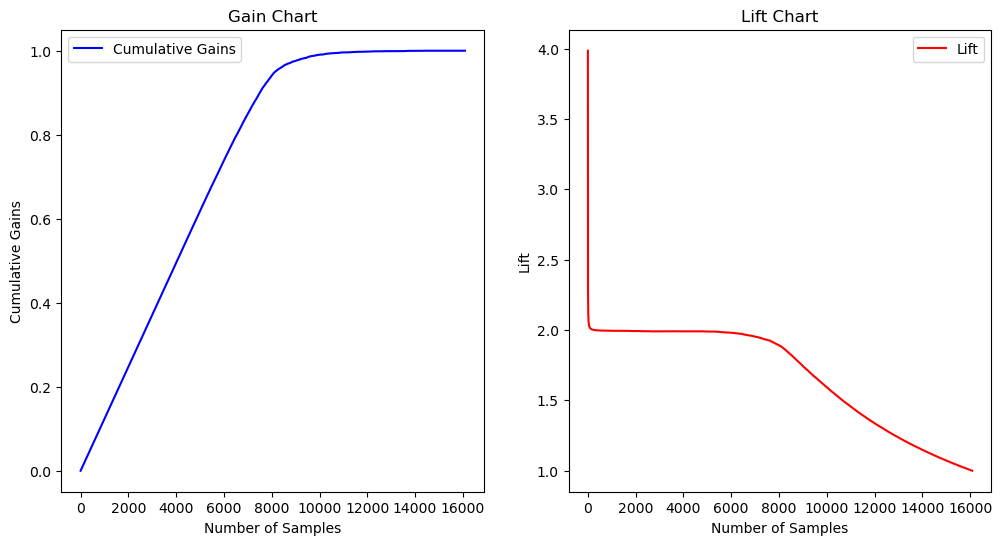

In [8]:
import matplotlib.pyplot as plt

# Function to plot Lift and Gain Charts
def plot_lift_gain_chart(y_true, y_pred_mlp_proba):
    # Convert "yes" and "no" labels to binary labels (1 and 0)
    y_true_binary = y_true.replace({'yes': 1, 'no': 0}).values

    # Sort the probabilities and true labels in descending order
    sorted_indices = np.argsort(y_pred_mlp_proba)[::-1]
    sorted_y_true = y_true_binary[sorted_indices]

    # Calculate the cumulative gains
    cum_gains = np.cumsum(sorted_y_true) / np.sum(sorted_y_true)

    # Calculate the lift values correctly
    baseline = np.linspace(0, 1, len(y_true))
    lift = cum_gains / baseline

    # Plot the Lift and Gain Charts
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(cum_gains, label='Cumulative Gains', color='b')
    plt.xlabel('Number of Samples')
    plt.ylabel('Cumulative Gains')
    plt.title('Gain Chart')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(lift, label='Lift', color='r')
    plt.xlabel('Number of Samples')
    plt.ylabel('Lift')
    plt.title('Lift Chart')
    plt.legend()
    plt.show()

# Plot the Lift and Gain Charts
plot_lift_gain_chart(y_test, y_pred_mlp_proba)

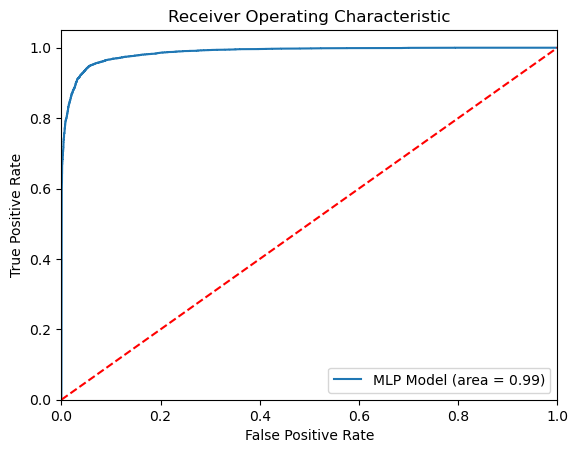

AUC Score:  0.9862723866363057


In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

# Convert 'yes' and 'no' labels to binary labels (1 and 0)
y_test_binary = y_test.replace({'yes': 1, 'no': 0}).values

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_mlp_proba)

# Now, you can plot the ROC curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label='MLP Model (area = %0.2f)' % roc_auc_score(y_test_binary, y_pred_mlp_proba))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculating AUC
auc = roc_auc_score(y_test_binary, y_pred_mlp_proba)
print("AUC Score: ", auc)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the MLP Classifier model
mlp_model = MLPClassifier()

# Define the hyperparameter grid for Randomized Search
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  # Number of neurons in hidden layers
    'activation': ['logistic', 'tanh', 'relu'],  # Activation functions
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # L2 regularization term
    'learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rate
    'max_iter': [100, 200, 300, 400, 500],  # Maximum number of iterations
}

# Create the Randomized Search CV object
random_search_mlp = RandomizedSearchCV(
    mlp_model, 
    param_distributions=param_dist, 
    n_iter=100,  # Number of random combinations to try
    scoring='accuracy',  # You can use different scoring metrics
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    verbose=1  # Show progress during the search
)

# Fit the Randomized Search on the training data
random_search_mlp.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_random_mlp = random_search_mlp.best_params_
best_model_random_mlp = random_search_mlp.best_estimator_

# Evaluate the best model on the test data
y_pred_best_random_mlp = best_model_random_mlp.predict(X_test)
accuracy_best_random_mlp = accuracy_score(y_test, y_pred_best_random_mlp)

print(f'Best Hyperparameters (MLP Classifier - Randomized Search): {best_params_random_mlp}')
print(f'Best Model Accuracy (MLP Classifier - Randomized Search): {accuracy_best_random_mlp}')

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the MLP Classifier model
mlp_model = MLPClassifier()

# Define the hyperparameter grid for Grid Search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  # Number of neurons in hidden layers
    'activation': ['logistic', 'tanh', 'relu'],  # Activation functions
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # L2 regularization term
    'learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rate
    'max_iter': [100, 200, 300, 400, 500],  # Maximum number of iterations
}

# Create the Grid Search CV object
grid_search_mlp = GridSearchCV(
    mlp_model, 
    param_grid=param_grid, 
    scoring='accuracy',  # You can use different scoring metrics
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    verbose=1  # Show progress during the search
)

# Fit the Grid Search on the training data
grid_search_mlp.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_grid_mlp = grid_search_mlp.best_params_
best_model_grid_mlp = grid_search_mlp.best_estimator_

# Evaluate the best model on the test data
y_pred_best_grid_mlp = best_model_grid_mlp.predict(X_test)
accuracy_best_grid_mlp = accuracy_score(y_test, y_pred_best_grid_mlp)

print(f'Best Hyperparameters (MLP Classifier - Grid Search): {best_params_grid_mlp}')
print(f'Best Model Accuracy (MLP Classifier - Grid Search): {accuracy_best_grid_mlp}')